In [1]:
import tensorflow as tf
from tensorflow.keras import losses , metrics , applications ,layers  , models , callbacks , optimizers

import numpy as np 
import matplotlib.pyplot as plt 
plt.style.use("dark_background")

import os 
import shutil 
import PIL as Images
import cv2
from tqdm import tqdm
import pandas as pd
from PIL import Image
import gc

2024-03-24 03:04:24.574018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 03:04:24.574118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 03:04:24.751707: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# !mkdir .\datasets\kaggle
# os.environ['KAGGLE_USERNAME'] = 'prajwalsharma123'
# os.environ['KAGGLE_KEY']='6719f9750ed948ff6d82400eab62fe8c'

In [3]:
# !kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

In [4]:
# import zipfile
# zip_path = 'lgg-mri-segmentation.zip'
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall('datasets')
# os.remove(zip_path)

In [5]:
# shutil.rmtree('datasets/lgg-mri-segmentation')

In [6]:
base_dir = 'datasets/kaggle_3m/'
DataDirectories = os.listdir(base_dir)
len(DataDirectories)

112

In [7]:
configuration = {
    'im_h' : 256,
    'im_w' : 256,
    'im_c' : 3,
}

In [8]:
Patient_info = []
Image_paths = []
Mask_paths = []
Has_tumer = []

for directory in tqdm(DataDirectories):
    try:
        SubDirectory = os.listdir(base_dir + directory)

        image_keys = []
        mask_keys = []
        
        for sub_dir in SubDirectory:
            if sub_dir.endswith('.tif'):
                if(sub_dir.endswith('mask.tif')):
                    key = sub_dir.split('_')[-2]
                    mask_keys.append(key)
                else:
                    key = sub_dir.split('_')[-1][:-4]
                    image_keys.append(key)

        common_keys = np.intersect1d(image_keys,mask_keys)
        
        for key in common_keys:
#             print('reached')
            path = base_dir + directory + '/' + directory +'_'+ str(key)
            
            image_path = path + '.tif'
            mask_path = path + '_mask.tif'
        
            image = Image.open(image_path)
            mask = Image.open(mask_path)
            
            image_size = (configuration['im_h'],configuration['im_w'])
            image = image.resize(image_size)
            mask = mask.resize(image_size)

            image.save(image_path)
            mask.save(mask_path)
            
            has_tumer = (np.max(mask)>0)
            
            Image_paths.append(image_path)
            Mask_paths.append(mask_path)
            Has_tumer.append(has_tumer)
            Patient_info.append(directory)
            
    except Exception as e:
        print(base_dir + directory)
#         print(e)
        pass

#     break

  7%|▋         | 8/112 [00:00<00:07, 13.25it/s]

datasets/kaggle_3m/README.md


 42%|████▏     | 47/112 [00:04<00:05, 12.57it/s]

datasets/kaggle_3m/data.csv


100%|██████████| 112/112 [00:12<00:00,  9.16it/s]


In [9]:
col = zip(Patient_info,Image_paths,Mask_paths,Has_tumer)
Data = pd.DataFrame(col,
                    columns = ['Patient_info',
                               'Image_paths',
                               'Mask_paths',
                               'Has_tumer'],       
                   )
Data.sample(5)

,Patient_info,Image_paths,Mask_paths,Has_tumer
1417,TCGA_CS_6667_20011105,datasets/kaggle_3m/TCGA_CS_6667_20011105/TCGA_...,datasets/kaggle_3m/TCGA_CS_6667_20011105/TCGA_...,False
132,TCGA_DU_8168_19970503,datasets/kaggle_3m/TCGA_DU_8168_19970503/TCGA_...,datasets/kaggle_3m/TCGA_DU_8168_19970503/TCGA_...,True
3030,TCGA_DU_A5TS_19970726,datasets/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_...,datasets/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_...,True
1044,TCGA_FG_6690_20020226,datasets/kaggle_3m/TCGA_FG_6690_20020226/TCGA_...,datasets/kaggle_3m/TCGA_FG_6690_20020226/TCGA_...,False
2717,TCGA_DU_5871_19941206,datasets/kaggle_3m/TCGA_DU_5871_19941206/TCGA_...,datasets/kaggle_3m/TCGA_DU_5871_19941206/TCGA_...,True


In [10]:
Data.describe()

,Patient_info,Image_paths,Mask_paths,Has_tumer
count,3929,3929,3929,3929
unique,110,3929,3929,2
top,TCGA_HT_A61A_20000127,datasets/kaggle_3m/TCGA_DU_7306_19930512/TCGA_...,datasets/kaggle_3m/TCGA_DU_7306_19930512/TCGA_...,False
freq,88,1,1,2556


In [11]:
Data.Has_tumer.value_counts()

Has_tumer
False    2556
True     1373
Name: count, dtype: int64

In [12]:
# import pandas as pd
# import numpy as np
# from tensorflow.keras.utils import Sequence

# class CustomDataGenerator(Sequence):
#     def __init__(self, X_images , Y_masks , batch_size=32, shuffle=True, augment=True ,prefetch_size = 1 ):
        
#         self.X_images = X_images
#         self.Y_masks = Y_masks  
        
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.augment = augment
#         self.prefetch_size = prefetch_size
#         self.indexes = np.arange(len(X_images))
    
#     def __len__(self):
#         return len(self.X_images) // self.batch_size

#     def __getitem__(self, index):
#         start_index = index * self.batch_size
#         end_index = (index + 1) * self.batch_size
#         batch_indexes = self.indexes[start_index:end_index]

#         batch_x = []
#         batch_y = []

#         for idx in batch_indexes:
#             image_address = self.X_images[idx]
#             mask_address = self.Y_masks[idx]
            
#             image = Image.open(image_address)
#             mask = Image.open(mask_address)
            
#             # Load data corresponding to file_address
#             # Example: load image from file_address using a function like cv2.imread()

#             # Apply data augmentation if enabled
# #             if self.augment:
#                 # Example: apply augmentation functions to the loaded data

#             # Append loaded and augmented data to batch_x and batch_y
#             batch_x.append(image)
#             batch_y.append(mask)

#         return np.array(batch_x), np.array(batch_y)

#     def on_epoch_end(self):
#         if self.shuffle:
#             self.indexes = np.random.shuffle(self.indexes)

# #     def prefetch(self, dataset):
# #         return dataset.prefetch(buffer_size = self.prefetch_size)


# data_generator = CustomDataGenerator(Data['Image_paths'].values,Data['Mask_paths'].values, augment=True)
# # prefetched_data_generator = data_generator.prefetch(data_generator)

# # Now you can use prefetched_data_generator for training or validation with Keras models
# # Example:
# # model.fit(prefetched_data_generator, ...)

100%|██████████| 1373/1373 [00:06<00:00, 227.80it/s]


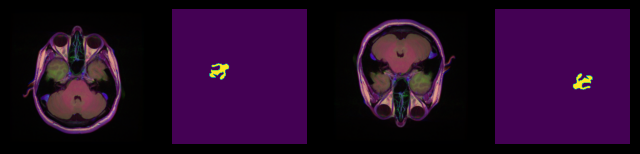

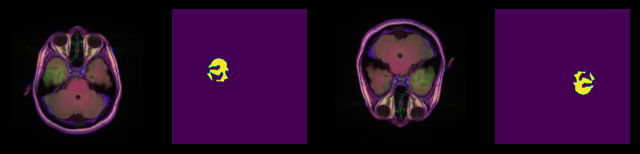

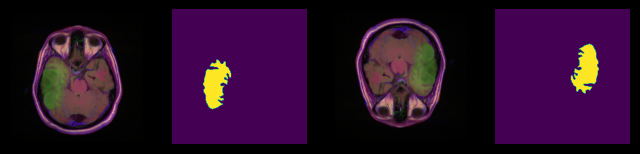

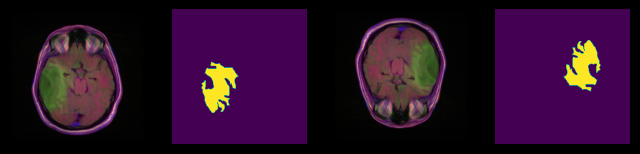

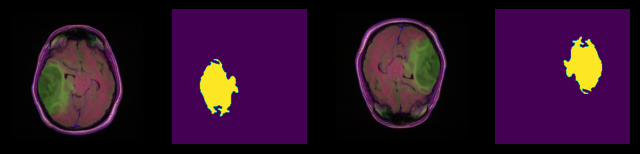

In [13]:
Tumer_Data = Data[Data.Has_tumer==True]
n = 5
for p_info , image_path , mask_path , _ in tqdm(Tumer_Data.values):

    image = Image.open(image_path)
    mask = Image.open(mask_path)
    
    aug_image = image.transpose(Image.FLIP_LEFT_RIGHT).transpose(Image.FLIP_TOP_BOTTOM)
    aug_mask = mask.transpose(Image.FLIP_LEFT_RIGHT).transpose(Image.FLIP_TOP_BOTTOM)
    
    aug_image_path = image_path.split('.')[0]+'_augmented.' + image_path.split('.')[1]
    aug_mask_path = mask_path.split('.')[0]+'_augmented.' + mask_path.split('.')[1]
    
    aug_image.save(aug_image_path)
    aug_mask.save(aug_mask_path)
    
    Data.loc[len(Data)] = [p_info , aug_image_path , aug_mask_path ,True]
    
    if(n>0):
        plt.figure(figsize=(8,2))
        
        plt.subplot(1,4,1)
        plt.imshow(image)
        plt.axis('off')
        
        plt.subplot(1,4,2)
        plt.imshow(mask)
        plt.axis('off')
        
        plt.subplot(1,4,3)
        plt.imshow(aug_image)
        plt.axis('off')
        
        plt.subplot(1,4,4)
        plt.imshow(aug_mask)
        plt.axis('off')
        n-=1


In [14]:
Data.Has_tumer.value_counts()

Has_tumer
True     2746
False    2556
Name: count, dtype: int64

In [15]:
X = []
Y = []
for p_info , image_path , mask_path , _ in tqdm(Data.values):
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    X.append(image)
    Y.append(mask)

100%|██████████| 5302/5302 [00:04<00:00, 1309.85it/s]


In [18]:
np.shape(X),np.shape(Y)

((5302, 256, 256, 3), (5302, 256, 256))

In [16]:
X = np.array(X,dtype = 'float32')/255.0
Y = np.array(Y,dtype = 'float32')/255.0
X.shape ,Y.shape , X[0].max()

((5302, 256, 256, 3), (5302, 256, 256), 0.92941177)

In [17]:
Y = np.expand_dims(Y,axis=-1)
Y.shape

(5302, 256, 256, 1)

In [18]:
gc.collect()

0

In [19]:
def display_images(List = None,Labels = None,size = 2,cmap = 'jet'):
    if(List!=None):
        n = len(List)
        plt.figure(figsize = (size * n , size))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.imshow(List[i],cmap = cmap)
            plt.axis('off')
            if(Labels != None):
                plt.title(Labels[i],color = 'cyan')
        plt.show()

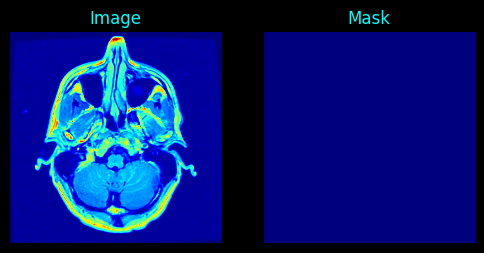

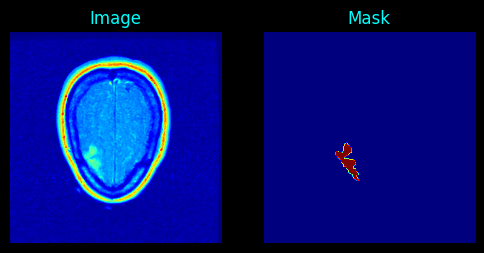

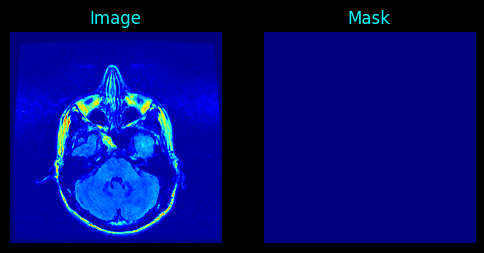

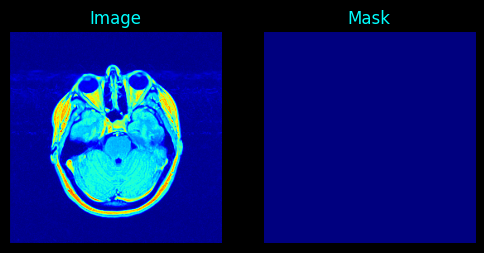

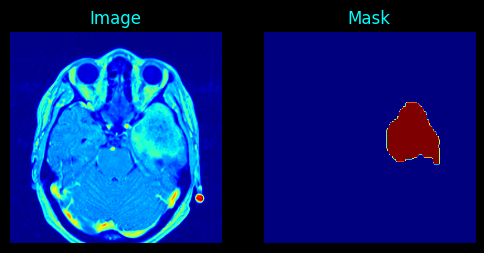

In [25]:
num = 5
seed = 10
np.random.seed(seed)
indices = np.random.randint(low = 0 , high = len(X),size = (num,))
for i in indices:
    x = np.max(X[i],axis=-1)
    y = Y[i]
    display_images([x,y],size = 3,Labels = ['Image','Mask'],cmap='jet')  #Note : Cmap could be applied to a one channel only 

In [26]:
# pip install keras_segmentation

In [27]:
# import keras_segmentation.models.unet as seg_model

In [28]:
# # mask_shape = (configuration['im_h'],configuration['im_w'] , 1)

# SegModel = seg_model.unet(2,configuration['im_h'],configuration['im_w'],configuration['im_c'])

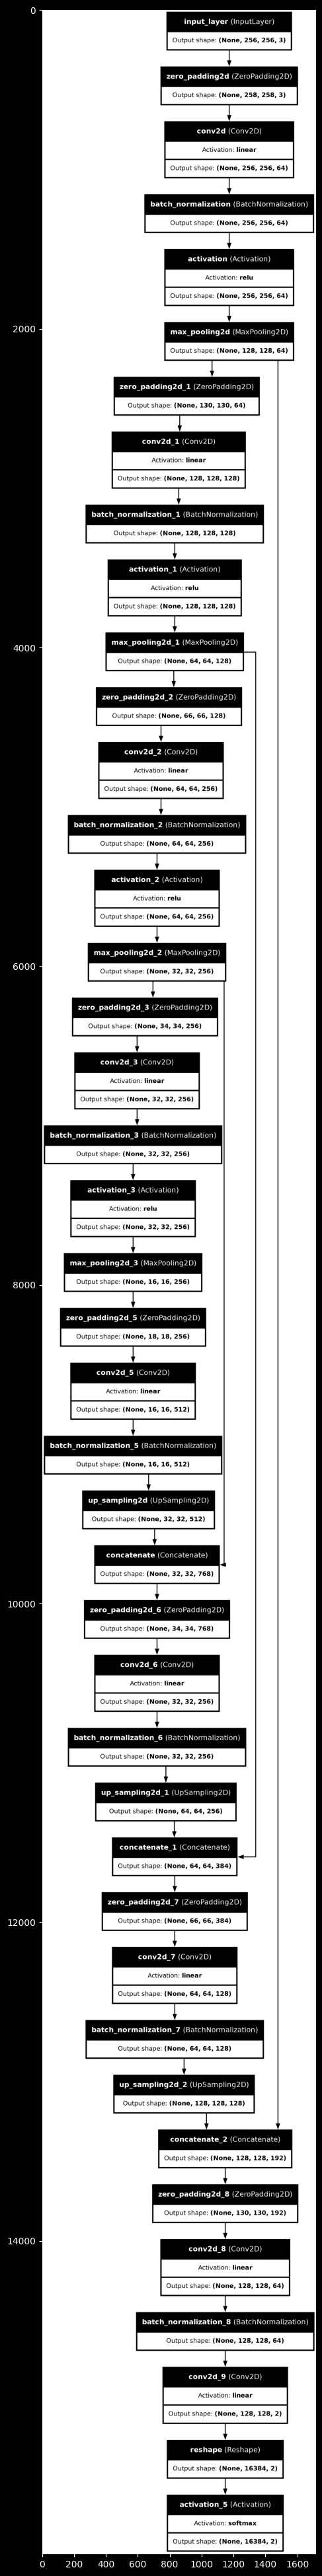

In [13]:
# model_file_path = 'segmentation_model.png'
# model_plot = tf.keras.utils.plot_model(SegModel,to_file=model_file_path,show_shapes = True,show_layer_activations=True,show_layer_names=True,)

# plt.figure(figsize=(20,50))
# model_plot = plt.imread(model_file_path)
# plt.imshow(model_plot)
# plt.show()

In [15]:
# SegModel.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 258, 258,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ max_pooling2d[0]… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     73,856 │ zero_padding2d_1… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 66, 66,    │          0 │ max_pooling2d_1[… │
│ (ZeroPadding2D)     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    295,168 │ zero_padding2d_2… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 34, 34,    │          0 │ max_pooling2d_2[

 Total params: 4,471,746 (17.06 MB)

 Trainable params: 4,468,418 (17.05 MB)

 Non-trainable params: 3,328 (13.00 KB)

In [ ]:
# fn_output = SegModel.layers[-4].output
# fn_output = layers.UpSampling2D(size=(2,2))(fn_output)
# # print(fn_output.shape)
# fn_output = layers.Concatenate()([SegModel.layers[2].output , fn_output])
# fn_output = layers.Conv2D(64,kernel_size = 3,strides = 1,padding = 'Same',activation = 'relu')(fn_output)
# fn_output = layers.BatchNormalization()(fn_output)
# fn_output = layers.Conv2D(1,kernel_size = 3 ,strides = 1,padding = 'Same',activation = 'sigmoid')(fn_output)

In [ ]:
# SubModel = models.Model(SegModel.input , fn_output)
# SubModel.summary(line_length = 100)

In [29]:
General_Config = {
    'image_shape' : (256,256),
    'n_channel' : 3,
    'n_class' : 2,
}
Model_Config = {
    'n_level' : 3,
    'n_unit' : 32, ## start Units  
    'scaling_factor' : 2,
    'kernel_size' : 3,
    'n_block_layer' : 2, ## Number of layers in Each Block ..
    'activation' : 'relu',
    'strides':1,
}

In [30]:
def Unit_Block(x ,n_unit = 64):
    n_layer = Model_Config['n_block_layer']
    for j in range(n_layer): 
        x = layers.Conv2D(n_unit , kernel_size = Model_Config['kernel_size'],
                          padding='same' , strides = Model_Config['strides'],
                          activation = Model_Config['activation'],
                        )(x)
    x = layers.BatchNormalization()(x)
    return x

def Decoder_Block(x,y):
    scale = Model_Config['scaling_factor']
    x = layers.UpSampling2D(scale)(x)
    x = layers.Concatenate()([x,y])
    return x

In [31]:
def Encode(x):
    scale = Model_Config['scaling_factor']
    n_level = Model_Config['n_level']
    n_unit = Model_Config['n_unit']
    
    Encoder_List = []
    for i in range(n_level):
        x = Unit_Block(x,n_unit)
        Encoder_List.append(x)
        x = layers.MaxPool2D(scale,scale)(x)
        n_unit *= scale
    return x , Encoder_List

def Decode(x,Encoder_List):
    scale = Model_Config['scaling_factor']
    n_level = Model_Config['n_level']
    n_unit = Model_Config['n_unit'] * (scale **n_level)
    
    for i in range(n_level):
        y = Encoder_List.pop()
        x = Decoder_Block(x,y)
        n_unit = int(n_unit /scale)
        x = Unit_Block(x,n_unit)
    return x

In [32]:
def BuildUnet(backbone=None):
    image_shape = General_Config['image_shape']+(General_Config['n_channel'],)
    n_class = General_Config['n_class']
    
    fn_input = layers.Input(shape = image_shape)
    ## Encoding ................................................
    x , Encoder_List = Encode(fn_input)
    ## Base Part ...............................................
    scale = Model_Config['scaling_factor']
    n_level = Model_Config['n_level']
    n_unit = Model_Config['n_unit'] * (scale **n_level)
    x = Unit_Block(x,n_unit)
    ## Decoder Part..............................................
    x = Decode(x,Encoder_List)
    ## Ending Part ..............................................
    if(n_class==2):
        fn_output = layers.Conv2D(1 ,Model_Config['kernel_size'] ,activation='sigmoid',padding = 'same')(x)
    else:
        fn_output = layers.Conv2D(n_class ,Model_Config['kernel_size'] ,activation = 'softmax',padding = 'same')(x)
        
    ### Build Model ==================================================|
    Model = models.Model(fn_input ,fn_output,name = 'Unet_Model')
    return Model

In [33]:
SubModel = BuildUnet()
SubModel.summary()

Model: "Unet_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 1,949,953 (7.44 MB)

 Trainable params: 1,948,545 (7.43 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [34]:
def jaccard_coef(Y_true , Y_pred):
    smooth = 1.0
    Y_true = layers.Flatten()(Y_true)
    Y_pred = layers.Flatten()(Y_pred)
    intersection = tf.reduce_sum(Y_true * Y_pred)
    union = tf.reduce_sum(Y_true) + tf.reduce_sum(Y_pred) - intersection 
    return (intersection+smooth) / (union + smooth)

def jaccard_loss(Y_true ,Y_pred):
    return 1-jaccard_coef(Y_true,Y_pred)

In [47]:
loss = [jaccard_loss]
metrics_ = ['accuracy', jaccard_coef]
lr = 0.001
SubModel.compile(
    optimizer = optimizers.Adam(learning_rate=lr),
    loss = loss,
    metrics = metrics_,
)

In [48]:
model_weights_path = 'seg_model_best3.weights.h5'
checkpoint_callback = callbacks.ModelCheckpoint(  ## To save Best Models
    model_weights_path,
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True, ## will save best weights. 
    save_weights_only = True, ## If false will save whole model .. .
    mode = 'auto', # if monitor val_loss that it will be min else if val_accuracy that it will be Max..
    save_freq = 'epoch', ## we will do this after every epoch .
)

plateau_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, ## reduce by this factor . ## lr = lr*0.1
    patience=2, ## wait till these number of epochs ,
    verbose=1,
    mode='auto', ## similar to what studied above,,i..e Min or Max..
    min_delta=0.0, ## if change is less than delta than we will consider it as no improvement . 
    cooldown=0,  ## to wait after we have updated our lr ,,
    min_lr=0, ## dont go below this lr.
)

In [38]:
from sklearn.model_selection import train_test_split

X_train,X_test ,Y_train,Y_test = train_test_split( X,Y,test_size = 0.15,random_state = 42)
X_train,X_val ,Y_train,Y_val = train_test_split( X_train,Y_train,test_size = 0.1,random_state = 42)

In [39]:
X_train.shape , X_test.shape ,X_val.shape ,Y_train.shape ,Y_test.shape , Y_val.shape

((4055, 256, 256, 3),
 (796, 256, 256, 3),
 (451, 256, 256, 3),
 (4055, 256, 256, 1),
 (796, 256, 256, 1),
 (451, 256, 256, 1))

In [40]:
# batch_size = 24
# Train_dataset = tf.data.Dataset.from_tensor_slices([X_train,Y_train]).shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
# Val_dataset = tf.data.Dataset.from_tensor_slices([X_val,Y_val]).shuffle(buffer_size=len(X_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [41]:
# Train_dataset , Val_dataset

In [42]:
del X ,Y 
# del X_train,Y_train ,X_val ,Y_val

In [43]:
History = {}
def AddToHistory(history):
    for metric,values  in history.history.items():
        if(metric not in History.keys()):
            History[metric] = []
        History[metric] += values

In [49]:
history = SubModel.fit(X_train ,Y_train ,
            validation_data=[X_val , Y_val],
            callbacks=([checkpoint_callback , 
                        plateau_callback]
                    ),
             batch_size = 32,
             epochs = 20,
            )
AddToHistory(history)

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 87s 599ms/step - accuracy: 0.9971 - jaccard_coef: 0.8167 - loss: 0.1833 - val_accuracy: 0.9962 - val_jaccard_coef: 0.7706 - val_loss: 0.2294 - learning_rate: 0.0010
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 69s 543ms/step - accuracy: 0.9970 - jaccard_coef: 0.8174 - loss: 0.1826 - val_accuracy: 0.9962 - val_jaccard_coef: 0.7714 - val_loss: 0.2286 - learning_rate: 0.0010
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 69s 542ms/step - accuracy: 0.9971 - jaccard_coef: 0.8200 - loss: 0.1800 - val_accuracy: 0.9962 - val_jaccard_coef: 0.7684 - val_loss: 0.2316 - learning_rate: 0.0010
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9971 - jaccard_coef: 0.8186 - loss: 0.1814
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
127/127 ━━━━━━━━━━━━━━━━━━━━ 69s 542ms/step - accuracy: 0.9971 - jaccard_coef: 0.8187 - loss: 0.1813 - val_accuracy: 0.9960 - val_jaccard_coef: 0.7637 - val_loss: 0.2363 - learning_rate: 0.0010
Epoc

In [50]:
History

{'accuracy': [0.9672644138336182,
  0.9876729846000671,
  0.9886674284934998,
  0.9895653128623962,
  0.990386962890625,
  0.9903006553649902,
  0.9907897114753723,
  0.9913990497589111,
  0.99186110496521,
  0.9922250509262085,
  0.9925278425216675,
  0.9927375912666321,
  0.9927182793617249,
  0.9931677579879761,
  0.993228554725647,
  0.9935162663459778,
  0.9937700629234314,
  0.9940361976623535,
  0.994286835193634,
  0.9949344992637634,
  0.9949725866317749,
  0.9952161312103271,
  0.9952651262283325,
  0.9953335523605347,
  0.9954959154129028,
  0.9955341815948486,
  0.995596170425415,
  0.9957891702651978,
  0.9956980347633362,
  0.9958655834197998,
  0.9962010383605957,
  0.9962995648384094,
  0.9963793158531189,
  0.9964349269866943,
  0.9964932203292847,
  0.9965499043464661,
  0.9965841770172119,
  0.9966562986373901,
  0.9966920018196106,
  0.9966891407966614,
  0.9968044757843018,
  0.9968812465667725,
  0.9969043135643005,
  0.9969161152839661,
  0.9969435930252075,
  0.

In [51]:
SubModel.load_weights(model_weights_path)

In [52]:
gc.collect()

5477

In [53]:
SubModel.evaluate(X_train,Y_train)

127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.9974 - jaccard_coef: 0.8368 - loss: 0.1632


[0.165677011013031, 0.9973576068878174, 0.8343230485916138]

In [54]:
SubModel.evaluate(X_test,Y_test)

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9962 - jaccard_coef: 0.7808 - loss: 0.2192

2024-03-24 04:44:06.680169: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[28,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,96,256,256]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-24 04:44:06.958287: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.278233049s
Trying algorithm eng0{} for conv (f32[28,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,96,256,256]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2

25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9962 - jaccard_coef: 0.7803 - loss: 0.2197


[0.2253226488828659, 0.9962038397789001, 0.7746773362159729]

In [55]:
Y_pred = SubModel.predict(X_test,verbose = 1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step


In [56]:
X_test.shape

(796, 256, 256, 3)

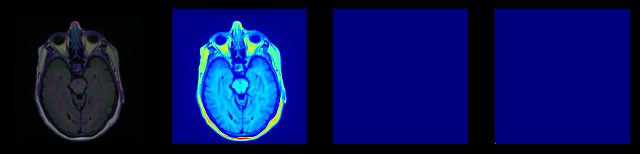

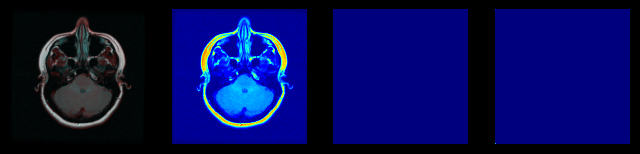

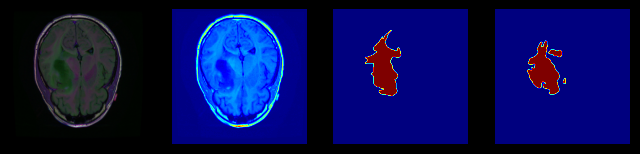

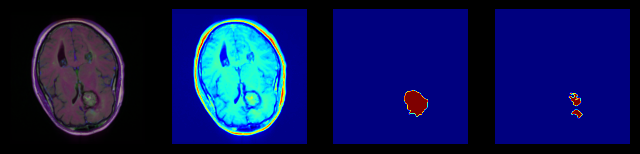

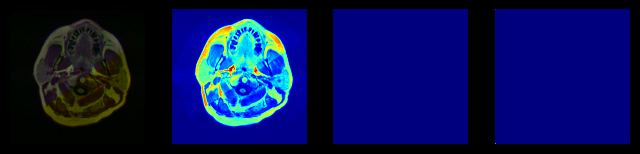

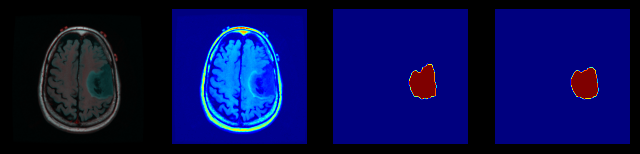

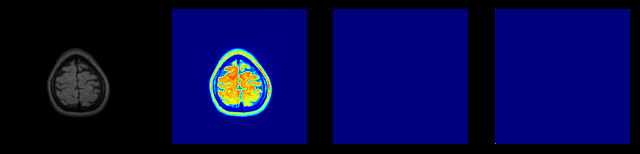

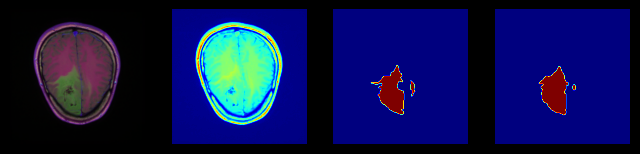

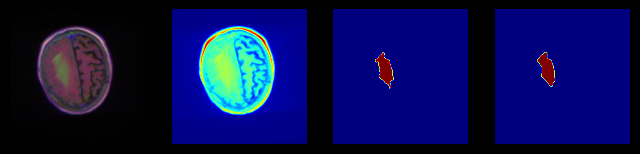

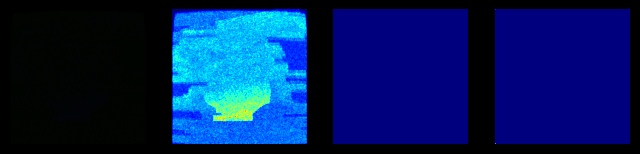

In [69]:
seed = 22
threshold = 0.002
np.random.seed(seed)
for num in np.random.randint(1,500,(10,)):
    x1 = X_test[num,:,:,0]
    x2 = X_test[num,:,:,1]
    x3 = X_test[num,:,:,2]
    x4 = np.mean(X_test[num],axis=-1)
    x5 = np.std(X_test[num],axis=-1)
    x6 = np.median(X_test[num],axis=-1)
#     display_images([x1,x2,x3,x4,x5,x6,Y_test[num],Y_pred[num]>threshold],size= 2.5,cmap= 'jet')
    display_images([X_test[num],x4,Y_test[num],Y_pred[num]])

In [58]:
def IOU(Y_true,Y_pred):
    smooth = 1
    Y_true = Y_true.flatten()
    Y_pred = Y_pred.flatten()
    intersection = np.sum(np.logical_and(Y_true,Y_pred))
    union = np.sum(np.logical_or(Y_true,Y_pred))
    
    return (intersection + smooth) / (union + smooth)

In [59]:
threshold = 0.5
IOU(Y_test,Y_pred>threshold)


0.7761663688366999

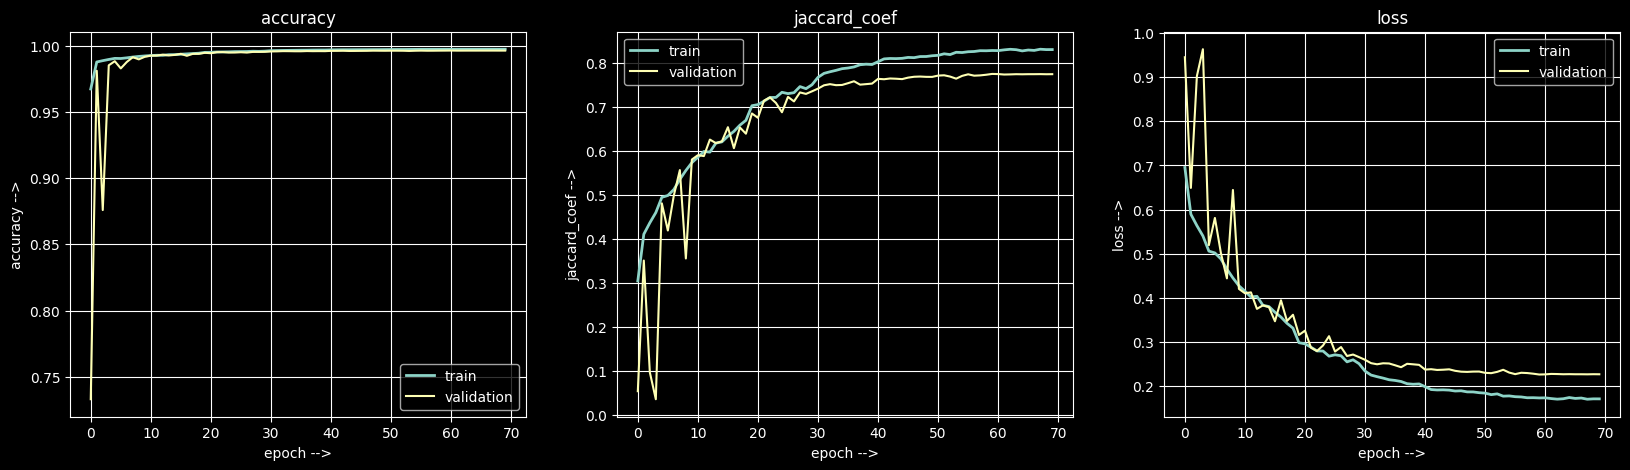

In [65]:
metric_List = list(History.keys())
plt.figure(figsize=(20,5))
for i,metric in enumerate(metric_List[:3],1):
    plt.subplot(1,3,i)
    plt.plot(History[metric],label='train',linewidth=2)
    plt.plot(History['val_'+ metric],label='validation',linewidth=1.5)
    plt.title(metric)
    plt.legend()
    plt.ylabel(metric + ' -->')
    plt.xlabel('epoch -->')
    plt.subplots_adjust(wspace=0.2, hspace=0.3) 
    plt.grid()